In [1]:
import numpy as np

class PricingEnvironment:
    def __init__(self, initial_inventory=100, max_days=30, base_price=50):
        self.initial_inventory = initial_inventory
        self.max_days = max_days
        self.base_price = base_price
        self.reset()

    def reset(self):
        self.inventory = self.initial_inventory
        self.day = 0
        self.demand_trend = np.random.uniform(0.8, 1.2)  # Random trend factor
        return self._get_state()

    def _get_state(self):
        return np.array([
            self.inventory / self.initial_inventory,  # Normalized inventory
            self.demand_trend,
            (self.max_days - self.day) / self.max_days,  # Normalized time remaining
            np.random.uniform(0.9, 1.1)  # Simulated competitor price multiplier
        ])

    def _calculate_demand(self, price_multiplier):
        # Price elasticity model
        base_demand = 10 * self.demand_trend
        price_elasticity = -1.5  # Typical for many products
        price = self.base_price * price_multiplier
        demand = base_demand * (price / self.base_price) ** price_elasticity
        return max(0, int(round(demand)))

    def step(self, action):
        # Action is a price multiplier: 0=0.9x, 1=0.95x, 2=1.0x, 3=1.05x, 4=1.1x
        price_multiplier = 0.9 + 0.05 * action
        demand = self._calculate_demand(price_multiplier)
        units_sold = min(demand, self.inventory)

        price = self.base_price * price_multiplier
        reward = price * units_sold

        self.inventory -= units_sold
        self.day += 1

        done = self.day >= self.max_days or self.inventory <= 0
        next_state = self._get_state()

        return next_state, reward, done, {
            'price': price,
            'units_sold': units_sold,
            'inventory': self.inventory,
            'day': self.day
        }

#DQN Implementation for Pricing

In [2]:
import torch
import torch.nn as nn
import random
from collections import deque

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(10000)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.action_dim = action_dim

    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            return q_values.argmax().item()

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def learn(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        current_q = self.policy_net(states).gather(1, actions)
        next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
        target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = nn.MSELoss()(current_q, target_q.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

#Training the Pricing Agent

In [3]:
def train_pricing_agent(episodes=1000, batch_size=64):
    env = PricingEnvironment()
    agent = DQNAgent(state_dim=4, action_dim=5)

    rewards_history = []
    inventory_history = []
    price_history = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)

            agent.memory.push(state, action, reward, next_state, done)
            agent.learn(batch_size)

            state = next_state
            total_reward += reward

            # Record data for analysis
            price_history.append(info['price'])
            inventory_history.append(info['inventory'])

        agent.update_epsilon()
        if episode % 10 == 0:
            agent.update_target_net()

        rewards_history.append(total_reward)
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

    return agent, {
        'rewards': rewards_history,
        'prices': price_history,
        'inventory': inventory_history
    }

Episode 0, Total Reward: 4890.00, Epsilon: 0.99
Episode 1, Total Reward: 4990.00, Epsilon: 0.99
Episode 2, Total Reward: 4995.00, Epsilon: 0.99
Episode 3, Total Reward: 4825.00, Epsilon: 0.98
Episode 4, Total Reward: 4752.50, Epsilon: 0.98
Episode 5, Total Reward: 4920.00, Epsilon: 0.97
Episode 6, Total Reward: 5027.50, Epsilon: 0.97
Episode 7, Total Reward: 4932.50, Epsilon: 0.96
Episode 8, Total Reward: 5012.50, Epsilon: 0.96
Episode 9, Total Reward: 5165.00, Epsilon: 0.95
Episode 10, Total Reward: 4900.00, Epsilon: 0.95


<ipython-input-2-849600452>:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states).to(self.device)


Episode 11, Total Reward: 5042.50, Epsilon: 0.94
Episode 12, Total Reward: 5085.00, Epsilon: 0.94
Episode 13, Total Reward: 4952.50, Epsilon: 0.93
Episode 14, Total Reward: 5085.00, Epsilon: 0.93
Episode 15, Total Reward: 4930.00, Epsilon: 0.92
Episode 16, Total Reward: 4885.00, Epsilon: 0.92
Episode 17, Total Reward: 5067.50, Epsilon: 0.91
Episode 18, Total Reward: 5027.50, Epsilon: 0.91
Episode 19, Total Reward: 4855.00, Epsilon: 0.90
Episode 20, Total Reward: 4795.00, Epsilon: 0.90
Episode 21, Total Reward: 4860.00, Epsilon: 0.90
Episode 22, Total Reward: 4930.00, Epsilon: 0.89
Episode 23, Total Reward: 4860.00, Epsilon: 0.89
Episode 24, Total Reward: 4835.00, Epsilon: 0.88
Episode 25, Total Reward: 4955.00, Epsilon: 0.88
Episode 26, Total Reward: 4947.50, Epsilon: 0.87
Episode 27, Total Reward: 4922.50, Epsilon: 0.87
Episode 28, Total Reward: 4810.00, Epsilon: 0.86
Episode 29, Total Reward: 4935.00, Epsilon: 0.86
Episode 30, Total Reward: 4867.50, Epsilon: 0.86
Episode 31, Total Re

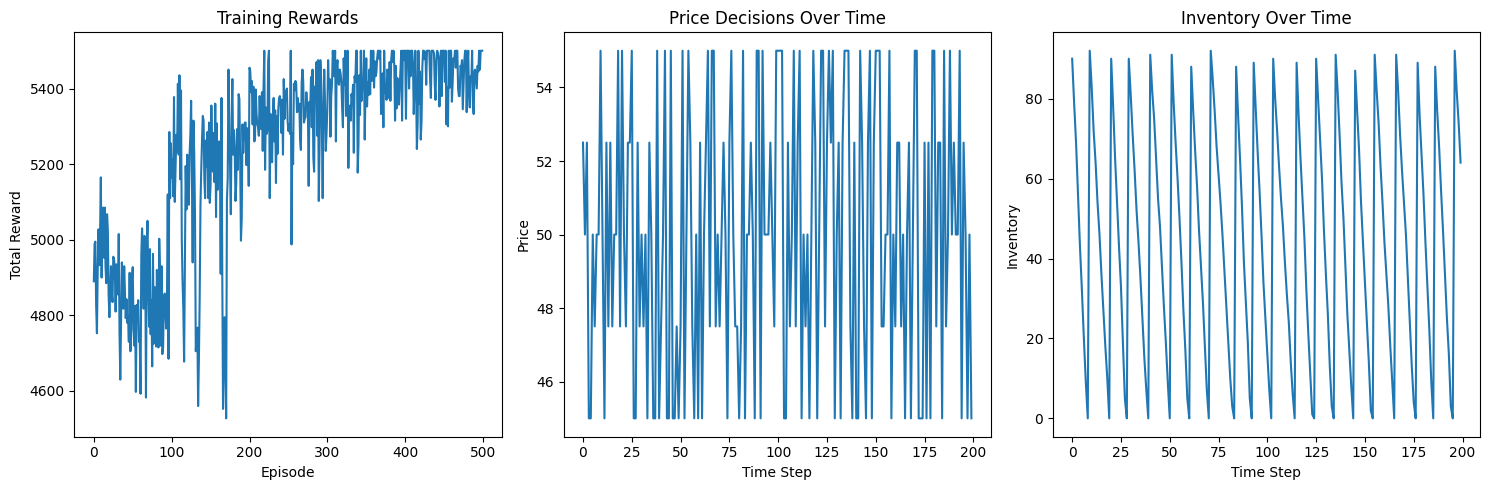

Average test reward: 5477.75


In [4]:
import matplotlib.pyplot as plt

def evaluate_agent(agent, env, num_episodes=10):
    total_rewards = []
    price_records = []
    sales_records = []

    for _ in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        episode_prices = []
        episode_sales = []

        while not done:
            action = agent.get_action(state)  # Use greedy policy
            next_state, reward, done, info = env.step(action)

            episode_reward += reward
            episode_prices.append(info['price'])
            episode_sales.append(info['units_sold'])
            state = next_state

        total_rewards.append(episode_reward)
        price_records.append(episode_prices)
        sales_records.append(episode_sales)

    return total_rewards, price_records, sales_records

def plot_results(rewards_history, price_history, inventory_history):
    plt.figure(figsize=(15, 5))

    # Plot rewards
    plt.subplot(1, 3, 1)
    plt.plot(rewards_history)
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    # Plot price decisions
    plt.subplot(1, 3, 2)
    plt.plot(price_history[:200])  # First 200 steps
    plt.title('Price Decisions Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Price')

    # Plot inventory
    plt.subplot(1, 3, 3)
    plt.plot(inventory_history[:200])
    plt.title('Inventory Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Inventory')

    plt.tight_layout()
    plt.show()

# After training:
trained_agent, training_data = train_pricing_agent(episodes=500)
plot_results(training_data['rewards'], training_data['prices'], training_data['inventory'])

# Evaluate the trained agent
test_env = PricingEnvironment()
test_rewards, test_prices, test_sales = evaluate_agent(trained_agent, test_env)
print(f"Average test reward: {np.mean(test_rewards):.2f}")